1.(30%) Documentation of the problem formulation: Clearly describe the objective function, the variables, the constraints, and the assumptions involved in formulating the problem.


improvement: 
1. Better dynamical model(drag adding to the problem)
2.Controller design for a distribution of initial states rather than one
3.Randomness in dynamics(add noise)


The objective function is to find the $\theta$ which will minimun the loss function  
$$l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$$
with batch intial input. 


$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}(T)||^2 \\
\quad & d(t+1)^{(i)} = d(t)^{(i)} + v(t)^{(i)} \Delta t + w(t)^{(i)}, \\
\quad & v(t+1)^{(i)} = v(t)^{(i)} + a(t)^{(i)}\Delta t + u(t)^{(i)} , \\
\quad & a(t)^{(i)} = f_{\theta}(x(t)^{(i)}), ~\forall t=1,...,T-1, ~i=1,...,N \\
\end{aligned}
$$

Variable:
Here, the input variable rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. N is the group of the initial input. The control input of the rocket is its acceleration $a(t)$. The output variable is the loss of the batch of input varible to measure if the rocket landing is reasonable $(d(t_f)= 0, v(t_f)= 0)$. Noises as a random varible is add into the d,v update function with Normal distribution.

Constrains: 
The rocket landing must follow the dynamic system for d and v shown above. In this case the acceleration includes three parts. Gravity acceleration,Thrust acceleration and acceleration based on drag. Since the drag equation is 
$$F_D= 1/2 * \rho * v^2 * C_D * A $$
the  acceleration of drag is depend on $v^2$, so $a_d$ is assumed to be 
$$a_d = c * v^2$$
where c is a constant.

Assuptions: 
1. simple model is perpendicular with the land, and has no rocket orientation, angular velocity. 
2. the batch intial input have a uniform distribution, where $10<d<20,  0<v<8$. 
3. linear relationship between input variable and hidden variable in the Netual Network 
4. linear relationship between output variable and hidden variable in the Netual Network 
5. Noises are Normal distribution, and relatively small
6. the rocket is always goes down




2. (40%) Programming: Like for homeworks, please push you code to your github repo. Please comment your code so that it is useful to you in the future.  

shown below. 10 groups of initial variables are calculated.





In [1]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [2]:
# environment parameters
state_group = 10
state_mat_initial=t.ones(state_group,2)
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
DRAG_ACCEL_COE = 0.0001  # drag accel constant 
#noise normal  1 for d; 2 for v
mean1=0
mean2=0
variance1=0.0001
variance2=0.0001

#rocket_mass=10
# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [3]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        
        c=t.tensor([[0,0],[0,1]]).float()
        v_1=t.matmul(state_mat_initial,c)
        
        delta_state_gravity = GRAVITY_ACCEL * FRAME_TIME * v_1

#         c=t.tensor([[0,0],[0,1]]).float()
#         v_1=t.matmul(state_mat_initial,c)
#         v = t.matmul(state,t.tensor([0,1]).float())
        
        # Thrust  & drag
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state1 = BOOST_ACCEL * FRAME_TIME * v_1    #thrust 
#         adrag = DRAG_ACCEL_COE * v * v 
#         drag=adrag*rocket_mass
       # if state[1] < 0
        #delta_state2 = DRAG_ACCEL_COE * v * v * FRAME_TIME * t.tensor([0., -1.]) * action  #add drag accele into v
        
        delta_state2 = DRAG_ACCEL_COE  * FRAME_TIME * t.matmul(state * state, t.tensor([[0., 0.],[0,-1]]))
        # Update velocity
        state = state + (delta_state1+ delta_state2  + delta_state_gravity) *action   # 3 accelerations matter
        
        # Noise
        w = t.tensor([1, 0]) * t.tensor(np.random.normal(mean1, variance1, 1))
        u = t.tensor([0, 1]) * t.tensor(np.random.normal(mean2, variance2, 1)) 
        noise1 = w + u
        noise =noise1.repeat(state_group,1)
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., 0],
                            [FRAME_TIME, 1.]])
        #n*2
        state = t.matmul(state, step_mat) + noise
        

        return state.float()

In [4]:
####need change 

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            #nn.Linear(dim_input, dim_hidden, dtype=t.float32),
            nn.Linear(dim_input, dim_hidden, dtype=t.float32),
            nn.Linear(dim_hidden, dim_output, dtype=t.float32))
            # You can add more layers here 

    def forward(self, state):
        action = self.network(state)
       # print(action)
        return action

In [5]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
        
    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
#         print('action', self.action_trajectory, '\n')
#         print(self.state_trajectory)
        error = self.error(state)
        return error

    @staticmethod
    def initialize_state():
#         state = [3.,11.]  # TODO: need batch of initial states
#         return t.tensor(state, requires_grad=False).float()
    
        A1=t.rand(state_group, 1)*10+10
        A2=t.rand(state_group, 1)*8
        A=t.cat([A1,A2],dim=1)
        B=t.tensor([[1,0], [0 ,-1]]).float()
        state = t.matmul(A,B).float()
        return t.tensor(state, requires_grad=False)
    
    def error(self, state):
        #return t.mean(state ** 2)        
        return (t.pow(state[:, 0], 2) + t.pow(state[:, 1], 2)).reshape(-1, 1).mean()

In [6]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch , momentum=1
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
#             print(loss)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()
    def visualize(self):
        data = np.array([[self.simulation.state_trajectory[i][j].detach().numpy() for i in range(self.simulation.T)]for j in range(state_group)])
        for i in range(state_group):
            x = data[i, :, 0]
            y = data[i, :, 1]
            plt.plot(x, y)
        plt.show()
    

<ipython-input-5-5e99b0f345b9>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return t.tensor(state, requires_grad=False)


[1] loss: 121.038
[2] loss: 86.329
[3] loss: 53.207
[4] loss: 34.068
[5] loss: 23.088
[6] loss: 16.089
[7] loss: 11.399
[8] loss: 7.922
[9] loss: 5.132
[10] loss: 3.396
[11] loss: 2.442
[12] loss: 1.858
[13] loss: 1.500
[14] loss: 1.227
[15] loss: 0.997
[16] loss: 0.797
[17] loss: 0.621
[18] loss: 0.472
[19] loss: 0.335
[20] loss: 0.230
[21] loss: 0.156
[22] loss: 0.108
[23] loss: 0.076
[24] loss: 0.054
[25] loss: 0.038
[26] loss: 0.026
[27] loss: 0.017
[28] loss: 0.012
[29] loss: 0.007
[30] loss: 0.005
[31] loss: 0.003
[32] loss: 0.003
[33] loss: 0.002
[34] loss: 0.002
[35] loss: 0.001
[36] loss: 0.000
[37] loss: 0.000
[38] loss: 0.000
[39] loss: 0.000
[40] loss: 0.000


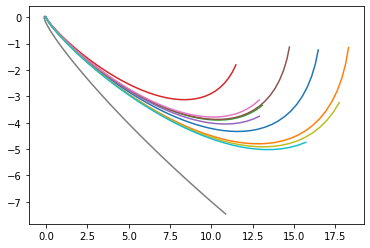

In [7]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 1  # action space dimensions


d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem

3. 3. (30%) Analysis of the results: Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

The figure above showsv-d curve for 10 initial variables. The loss converges for all the inputs.
The inputs are randomly picked from $10<d<20,  0<v<8$. The velocity will increase when the intial velocity is small and far away from the land. At some point the velocity drops to reach the final position. 
limitations: if the velocity cannot reach to 0 when landing the system will still run as drag force pulling up and velocity goes up, which is impossible in real life, That is the reason I picked the range of the input.
The noise I added is small and the same for each time step. 

Conclusion: the solution shown in THIS CASE show the convergence with 10 varibles in latent dimensions.
